## Loading the dataset and importing all necessary libraries



In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, GlobalMaxPooling1D, Conv1D, Activation
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint
import re


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('/content/drive/My Drive/sarcasmtweets.csv')
# Keeping only the neccessary columns
data = data[['Label','Tweet']]

In [0]:
data1 = pd.read_excel('/content/drive/My Drive/finalex.xlsx')
data1 = data[['Tweet']]

In [0]:
from statistics import mean
print(mean(data["Tweet"].str.len()))  # calculating the average tweet length for 
                                 #shortening and padding in pre-processsing step

90.47596782302665


## Data Pre-Processing

In [0]:
data["Tweet"] = data["Tweet"].apply(lambda x: x.lower())

print(data[ data['Label'] == 0].size)
print(data[ data['Label'] == 1].size)

data["Tweet"] = data["Tweet"].str.replace('#sarcasm','')
data["Tweet"] = data["Tweet"].str.replace('rt','')
data["Tweet"] = data["Tweet"].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

max_fatures = 8000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['Tweet'].values)
X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X, maxlen = 120)

42584
36976


In [0]:
print(mean(data1["Tweet"].str.len()))

90.47596782302665


## CNN creation (Sarcasm detection)

In [0]:
embed_dim = 50
sarcasm_model = Sequential()
sarcasm_model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
sarcasm_model.add(Dropout(0.2))
sarcasm_model.add(Conv1D(250,3,padding='valid',activation='relu',strides=1))
sarcasm_model.add(GlobalMaxPooling1D())
sarcasm_model.add(Dense(250))
sarcasm_model.add(Dropout(0.2))
sarcasm_model.add(Activation('relu'))       
#dropouts ignore randomly selected neurons increasing robustness

# We project onto a single unit output layer, and squash it with a sigmoid:
sarcasm_model.add(Dense(2))
sarcasm_model.add(Activation('sigmoid'))
sarcasm_model.compile(loss = 'binary_crossentropy', optimizer='adam' ,metrics = ['accuracy'])
print(sarcasm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 50)           400000    
_________________________________________________________________
dropout (Dropout)            (None, 120, 50)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 118, 250)          37750     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation (Activation)      (None, 250)               0

In [0]:
#Creating the training and testing samples for sarcasm detection
Y = pd.get_dummies(data['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 49)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35802, 120) (35802, 2)
(3978, 120) (3978, 2)


In [0]:
print(Y)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [0]:
#fitting the created model onto the training sample, using 5 epochs
#best model is saved for use later
batch_size = 64
checkpoint_path='/content/gdrive/My Drive/sarcasmModel.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True,mode = 'min')
history = sarcasm_model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 1,shuffle=True,validation_data=(X_test,Y_test),callbacks= [checkpoint]) 

Epoch 1/5
560/560 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7283
Epoch 00001: val_loss improved from inf to 0.41705, saving model to /content/gdrive/My Drive/sarcasmModel.h5
560/560 [==============================] - 8s 15ms/step - loss: 0.5168 - accuracy: 0.7283 - val_loss: 0.4170 - val_accuracy: 0.8079
Epoch 2/5
558/560 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.8443
Epoch 00002: val_loss improved from 0.41705 to 0.40139, saving model to /content/gdrive/My Drive/sarcasmModel.h5
560/560 [==============================] - 7s 13ms/step - loss: 0.3604 - accuracy: 0.8442 - val_loss: 0.4014 - val_accuracy: 0.8200
Epoch 3/5
559/560 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8834
Epoch 00003: val_loss did not improve from 0.40139
560/560 [==============================] - 8s 14ms/step - loss: 0.2847 - accuracy: 0.8833 - val_loss: 0.4278 - val_accuracy: 0.8052
Epoch 4/5
559/560 [===========================

In [0]:
score,acc = sarcasm_model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

63/63 - 0s - loss: 0.5452 - accuracy: 0.7974
score: 0.55
acc: 0.80


## Plotting Validation loss VS validation accuracy

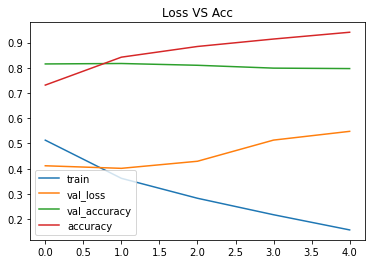

In [0]:
import matplotlib.pyplot as plt
plt.title('Loss VS Acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()
plt.show();

##Political Classification with sarcasm added

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# -*- coding: utf-8 -*-


import os
import re
import pickle

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

import pandas as pd
from tensorflow.python import keras
#import seaborn as sns
#import seaborn as sns1
import matplotlib.pyplot as plt

# from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


    
    

MAX_SEQ_LEN = 45 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 128

data = pd.read_excel('/content/drive/My Drive/finalex.xlsx')
# data = data[data['sentiment'] != 'Neutral']
train, test = train_test_split(data, random_state = 42, test_size=0.2)
#print(train.shape)
#print(test.shape)

def clean_text(tweet, mapping):
    space_replace = ["\n"]
    for s in space_replace:
        tweet = tweet.replace(s, " ")
    punctuations = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in punctuations:
        tweet = tweet.replace(s, "'")
    new_tweet = []
    for t in tweet.split(" "):
        if t in mapping:
            new_tweet.append(mapping[t])
        elif t.lower() in mapping:
            new_tweet.append(mapping[t.lower()])
        else:
            new_tweet.append(t)
    return ' '.join(new_tweet)

Mapping_expansion= {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
#mapping expansions used to convert shortforms to standard form
tweet_train_vec= [clean_text(tweet, Mapping_expansion) for tweet in train['Tweet'].values]
tweet_test_vec= [clean_text(tweet, Mapping_expansion) for tweet in test['Tweet'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(tweet_train_vec)
tweet_train_vec = tokenizer.texts_to_sequences(tweet_train_vec)
tweet_test_vec = tokenizer.texts_to_sequences(tweet_test_vec)

tweet_train_vec = pad_sequences(tweet_train_vec, maxlen=MAX_SEQ_LEN)
tweet_test_vec = pad_sequences(tweet_test_vec, maxlen=MAX_SEQ_LEN)

#label encoder encodes test labels to integer form
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['Party'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['Party'].values)
y_test = to_categorical(y_test)

from collections import Counter
ctr = Counter(train['Party'].values)
#creation of the naive bayes model pipeline
text_clf_nb = Pipeline([
    ('vect', CountVectorizer(stop_words='english',ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1e-4)),
])
#fitting the model to the training data 
text_clf_nb.fit(tokenizer.sequences_to_texts_generator(tweet_train_vec), y_train.argmax(axis=1))
predictions = text_clf_nb.predict(tokenizer.sequences_to_texts_generator(tweet_test_vec)) 
accuracy_naive_bayes=(predictions == y_test.argmax(axis = 1)).mean()
f1_score_naive_bayes=f1_score(y_test.argmax(axis = 1), predictions, average='weighted')


#creation of svm pipeline and fitting
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1,2))),('tfidf', TfidfTransformer(use_idf=False)),('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, random_state=19))])
text_clf_svm.fit(tokenizer.sequences_to_texts_generator(tweet_train_vec), y_train.argmax(axis=1))
predicted_svm = text_clf_svm.predict(tokenizer.sequences_to_texts_generator(tweet_test_vec))
accuracy_svm=(predicted_svm == y_test.argmax(axis = 1)).mean()
f1_score_svm=f1_score(y_test.argmax(axis = 1), predictions, average='weighted')

#creation of random forest pipeline and fitting
text_clf_rf = Pipeline([
    ('vect', CountVectorizer(stop_words='english',ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=500)), 
])
text_clf_rf.fit(tokenizer.sequences_to_texts_generator(tweet_train_vec), y_train.argmax(axis=1))
predictions = text_clf_rf.predict(tokenizer.sequences_to_texts_generator(tweet_test_vec)) 
accuracy_rf=(predictions == y_test.argmax(axis = 1)).mean()
f1_score_rf=f1_score(y_test.argmax(axis = 1), predictions, average='weighted')

In [0]:
#Bi-LSTM creation
model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model.add(SpatialDropout1D(0.6))#dropout added to avoid overfitting 
model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))#bidirectional layer to read backward & forward 
model.add(Conv1D(128, 4))#Borrowed from Image classification, assumes related info is locally grouped 
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))#Feed forward network used to interpret LSTM Output 
model.add(Dense(2, activation='softmax'))#Output of the model, 2 implies 2 output categories 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
#running the model for 30 epochs, beyond which it was overfitting
y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
model.fit(
        tweet_train_vec, 
        y_train, 
        #this is bad practice using test data for validation, in a real case would use a seperate validation set
        validation_data=(tweet_test_vec, y_test),  
        epochs=30, 
        batch_size=128,
        class_weight=cws,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [ModelCheckpoint('lstm.h5', monitor='val_accuracy', verbose=1, save_best_only=True)],
        verbose=1
    ) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2144 samples, validate on 536 samples
Epoch 1/30
2144/2144 [==============================] - 7s 3ms/step - loss: 0.6698 - accuracy: 0.6096 - val_loss: 0.6510 - val_accuracy: 0.6418

Epoch 00001: val_accuracy improved from -inf to 0.64179, saving model to lstm.h5
Epoch 2/30
2144/2144 [==============================] - 6s 3ms/step - loss: 0.6578 - accuracy: 0.6231 - val_loss: 0.6386 - val_accuracy: 0.6418

Epoch 00002: val_accuracy did not improve from 0.64179
Epoch 3/30
2144/2144 [==============================] - 6s 3ms/step - loss: 0.5749 - accuracy: 0.7057 - val_loss: 0.4754 - val_accuracy: 0.7948

Epoch 00003: val_accuracy improved from 0.64179 to 0.79478, saving model to lstm.h5
Epoch 4/30
2144/2144 [==============================] - 6s 3ms/step - loss: 0.2991 - accuracy: 0.8815 - val_loss: 0.3967 - val_accuracy: 0.8582

Epoch 00004: val_accuracy improved from 0.79478 to 0.85821, saving model to lstm.h5
Epoch 5/30
2144/2144 [==============================] - 6s 3ms/step -

In [0]:
#loading the best model which was saved
lstm_model = tf.python.keras.models.load_model('lstm.h5')

In [0]:
pickle.dump(text_clf_svm, open('svm.save','wb'))
pickle.dump(text_clf_nb, open('nb.save','wb'))
pickle.dump(text_clf_rf, open('rf.save','wb'))

In [0]:
loaded1 = pickle.load(open('svm.save','rb'))
pred1 = loaded1.predict(tokenizer.sequences_to_texts(tweet_test_vec))
loaded2 = pickle.load(open('nb.save','rb'))
pred2 = loaded2.predict(tokenizer.sequences_to_texts(tweet_test_vec))
loaded3 = pickle.load(open('rf.save','rb'))
pred3 = loaded3.predict(tokenizer.sequences_to_texts(tweet_test_vec))
loaded4 = lstm_model
pred4 = loaded4.predict(tweet_test_vec,verbose=1)
acc_svm = (np.mean(pred1 == y_test.argmax(axis = 1)))
acc_nb = (np.mean(pred2 == y_test.argmax(axis = 1)))
acc_rf = (np.mean(pred3 == y_test.argmax(axis = 1)))
acc_lstm = (pred4.argmax(axis = 1) == y_test.argmax(axis = 1)).mean()
#print(encoder.inverse_transform(pred))
summation = acc_svm + acc_nb + acc_rf

17/17 [==============================] - 1s 38ms/step


In [0]:
#for creation of ensemble model, weight of each classifier is calculated
#based on the accuracy it gives.

model_pred_ensm = [pred1,pred2,pred3]
weight_ensm = [acc_svm/summation,acc_nb/summation,acc_rf/summation]

In [0]:
print('List of weights:',weight_ensm)

List of weights: [0.3393371757925072, 0.335014409221902, 0.3256484149855908]


In [0]:
#with calculated weights, score of each class is calculated and class with 
#higher score is selected as the prediction
probability_dem = []
probability_rep = []
for counter in range(len(pred1)):
    dem_count = 0
    rep_count = 0
    for classifier in model_pred_ensm:
        if classifier[counter] == 0:
            dem_count += 1  
        else:
            rep_count += 1

    probability_dem.append(dem_count/(dem_count + rep_count))
    probability_rep.append(rep_count/(dem_count + rep_count))

dem_score = [0]*len(pred1)
rep_score = [0]*len(pred1)

for counter2 in range(len(pred1)):

    for classifier_count in range(3):
        if model_pred_ensm[classifier_count][counter2] == 0:
            dem_score[counter2] += weight_ensm[classifier_count] * probability_dem[counter2]
        else:
            rep_score[counter2] += weight_ensm[classifier_count] * probability_rep[counter2]


In [0]:
results = []
for element in range(len(pred1)):
    if dem_score[element] > rep_score[element]:
        results.append(0)
    else:
        results.append(1)
results = np.array(results)

In [0]:
#quantifying the results
accuracy_ensemble = (np.mean(results == y_test.argmax(axis = 1)))
print('Accuracy of the Ensemble model:', accuracy_ensemble)
print("Naive Bayes Accuracy:",accuracy_naive_bayes)
print("SVM Accuracy:",accuracy_svm)
print("Random Forest Accuracy:",accuracy_rf)
print("LSTM Accuracy:",acc_lstm)

Accuracy of the Ensemble model: 0.8861940298507462
Naive Bayes Accuracy: 0.8675373134328358
SVM Accuracy: 0.878731343283582
Random Forest Accuracy: 0.8432835820895522
LSTM Accuracy: 0.875


In [0]:
#getting the political data ready for sarcasm detection
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(test['Tweet'].values)
X1 = tokenizer.texts_to_sequences(test['Tweet'].values)
X1 = pad_sequences(X1, maxlen = 120)

In [0]:
#predicting the sarcasm for political data using trained model
answer = sarcasm_model.predict(X1,verbose = 1, batch_size=batch_size)
print(answer)

9/9 [==============================] - 0s 4ms/step
[[0.9910507  0.00926598]
 [0.9830547  0.017421  ]
 [0.84955937 0.13992351]
 ...
 [0.20843787 0.79754174]
 [0.00771692 0.9926472 ]
 [0.7450632  0.24621116]]


In [0]:
#index 0 ~ not sarcastic, index 1 ~ sarcastic (1-hot encoded)
#labelling values with high probability of sarcasm as sarcastic
answer = answer.tolist()
for item in answer:
    if item[1] > 0.9995:
        item[0] = 0
        item[1] = 1
    else:
        item[0] = 1
        item[1] = 0

print(answer)

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0],

In [0]:
#creation of a list with values 'Not' and 'Sarcastic'
#to later modify the sarcastic tweets
sarclist = []
for value in answer:
    if value[0] == 1:
        sarclist.append('Not')
    else:
        sarclist.append('Sarcastic')
print(sarclist)

['Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Sarcastic', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not',

In [0]:
#switching labels of tweets which are sarcastic
for i in range(len(results)):
    if sarclist[i] == 'Sarcastic' and results[i] == 0:
        results[i] = 1
    elif sarclist[i] == 'Sarcastic' and results[i] == 1:
        results[i] = 0

In [0]:
#Final accuracy of model with sarcasm included
accuracy_ensemble = (np.mean(results == y_test.argmax(axis = 1)))
print('Accuracy of the Ensemble model:', accuracy_ensemble)

Accuracy of the Ensemble model: 0.8805970149253731
